<a href="https://colab.research.google.com/github/BoshiLee/pytorch_learning/blob/main/mnist_cnn_classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision
!pip3 install pillow

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

`dset.MNIST(root, train=True, transform=None, transform=None, download=False)`

参数说明
1. root : processed/training.pt 和 processed/test.pt 的主目录
2. train : True = 训练集, False = 测试集
3. download : True = 从互联网上下载数据集，并把数据集放在root目录下. 如果数据集之前下载过，将处理过的数据（minist.py中有相关函数）放在processed文件夹下。
4. transform：對影像進行的處理

[其他資料集](https://codingdict.com/sources/py/torchvision.datasets/15805.html)

## 下載 Data 並實作歸一轉換

In [4]:
transform = transforms.Compose([transforms.Resize((28, 28)),  #將圖像轉換為 28 * 28
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) 
                                ]) #把灰階從0~255壓縮到0~1
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## training_loader 將 60000 筆圖像資料分成 600 個 batch

In [5]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

## 轉換圖片回可以被 pyplot 使用的格式

先前轉換 tensor 的方法，現在再轉換回去
![](https://imgur.com/MNL0WoI.jpg)

In [20]:
def img_conver(tensor: torch.Tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((1, 1, 1)) #將原本用 0~1 表達的灰階轉換爲 [c, h, w]
  image = image.clip(0, 1)
  return image

## 畫出 Dataset 的模樣

![](https://imgur.com/E99GZVX.jpg)

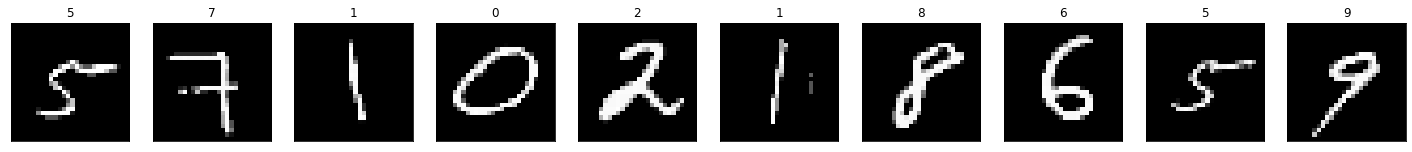

In [7]:
data_iter = iter(training_loader)
(images, labels) = data_iter.next()
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1) #
  con_im = img_conver(images[idx])
  plt.imshow(con_im)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(label=labels[idx].item())

[CNN conv2d 介紹](https://medium.com/codeda/pytorch-%E5%AD%B8%E7%BF%92-cnn-day8-20-20f636a3ffdc)

[LeNet 與其他 cnn 的介紹](https://medium.com/ching-i/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1-cnn-%E7%B6%93%E5%85%B8%E6%A8%A1%E5%9E%8B-lenet-alexnet-vgg-nin-with-pytorch-code-84462d6cf60c)

![](https://imgur.com/CkMwWxg.jpg)

conv1, conv2 extract by 5x5 kernal

max pooling with 2x2 kernal


In [8]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__();
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dorpout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10) 
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x)) 
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dorpout1(x)
    x = self.fc2(x)
    return x


## initail classfier
28 * 28 = 784 個數入端
h1 125 個節點
h2 65 個節點
最後輸出 10 個的機率

In [9]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dorpout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

## Training

In [11]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1) #返回每一列中最大值的那个元素，且返回索引（返回最大元素在这一列的行索引）
    running_loss += loss.item()# 將每一訓練完的結果加回總數
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5601, acc 85.1150 
validation loss: 0.1798, validation acc 94.4800 
epoch : 2
training loss: 0.1457, acc 95.7533 
validation loss: 0.1038, validation acc 96.9500 
epoch : 3
training loss: 0.0985, acc 97.1017 
validation loss: 0.0752, validation acc 97.8100 
epoch : 4
training loss: 0.0779, acc 97.6283 
validation loss: 0.0595, validation acc 98.2800 
epoch : 5
training loss: 0.0627, acc 98.0900 
validation loss: 0.0495, validation acc 98.3300 
epoch : 6
training loss: 0.0550, acc 98.3567 
validation loss: 0.0457, validation acc 98.5100 
epoch : 7
training loss: 0.0491, acc 98.5283 
validation loss: 0.0438, validation acc 98.6700 
epoch : 8
training loss: 0.0447, acc 98.6217 
validation loss: 0.0382, validation acc 98.7500 
epoch : 9
training loss: 0.0389, acc 98.8400 
validation loss: 0.0347, validation acc 98.7700 
epoch : 10
training loss: 0.0355, acc 98.9383 
validation loss: 0.0324, validation acc 98.8400 
epoch : 11
training loss: 0.0321, acc 99.0183 
va

**output ＝ 輸出預測原始分數結果**

[[ 1.2261069e+00 -5.7273965e+00 -4.1954031e+00 -3.6484995e+00
  -2.4565067e+00  1.3545682e+00  1.0387512e+01 -5.3805690e+00
   3.3601427e-01 -1.1107481e+01]
 [-1.3542774e+00 -1.5277462e+00 -3.5840625e-01 -5.0116652e-01
  -1.1355836e+00 -2.6571882e-01 -3.0248828e+00 -8.7250930e-01
   1.0844460e+00  8.2059675e-01]
 [ 1.0535399e+01 -2.8152704e+01 -8.2211943e+00 -1.5631153e+01
  -2.3035938e+01 -1.1812346e+01 -7.9027677e+00 -1.6740650e+01
  -9.5602045e+00 -6.5746822e+00]
 [ 1.6841581e+00 -4.0459881e+00 -5.2802405e+00 -3.5284595e+00
  -2.3374493e+00  1.3500847e+00  6.1499205e+00 -3.8639560e+00
   1.1507473e+00 -4.3945112e+00]
 [-3.8497939e+00 -1.0161068e+00 -1.2596358e+00  2.0538642e+00
  -2.2537014e+00  5.8658910e-01 -2.4626253e+00 -4.6215944e+00
   1.3722317e+00 -2.1360791e+00]
 [-5.1659923e+00 -6.8063464e+00 -2.8562734e+00 -2.0882232e+00
   3.8221255e-01 -2.9005632e+00 -1.3687369e+01  2.3450470e+00
  -9.0407890e-01  4.9399509e+00]
 [-4.0788898e+00 -3.7877328e+00 -1.4883008e+00  1.4184544e+00
  -5.2517614e+00 -2.2519267e+00 -1.5924767e+01  4.3276215e+00
  -1.1257372e+00  3.2146273e+00]
 [-7.7456293e+00 -7.5740331e-01  2.4926439e-02  7.7191372e+00
  -3.8455017e+00  8.3695984e-01 -1.0358748e+01 -3.1360974e+00
   1.6302195e+00  7.6127601e-01]
 [ 8.8252964e+00 -2.6196466e+01 -6.6488318e+00 -1.5089152e+01
  -2.0039001e+01 -1.1642657e+01 -7.0557885e+00 -1.6164896e+01
  -8.5983057e+00 -6.5639067e+00]
 [-3.0094376e+00 -2.9393325e+00 -1.1140752e+00 -1.6939263e+00
  -6.2546844e+00 -5.3861895e+00 -2.0039701e+01  9.1067991e+00
  -3.3135712e+00  2.5666628e+00]]

**pred = 取出最大的分數，表示 model 預測的結果，可以跟 label 比對**

[6 8 0 6 3 9 7 3 0 7]

比對方法

![比對方法](https://imgur.com/FgDRHIT.jpg)

## 繪製訓練 Loss

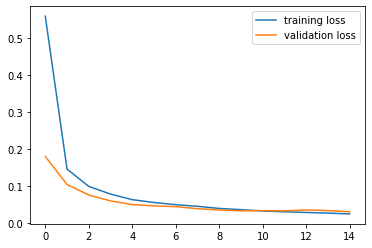

In [12]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

## 繪製訓練準確率

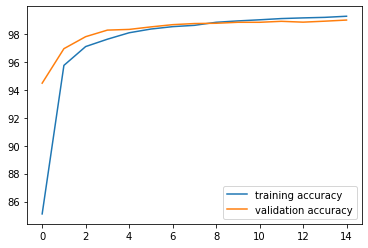

In [13]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

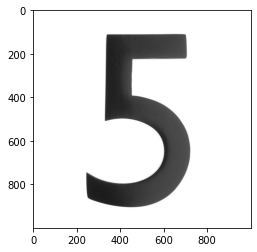

In [14]:
import requests
from PIL import Image, ImageOps
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)


## Test 將原圖轉換為可餵給神經網路的圖片

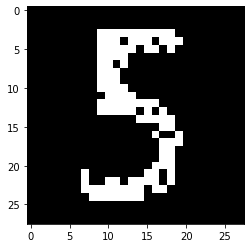

In [15]:
def transformImgToTensor(raw_image):
  raw_image = ImageOps.invert(raw_image) # 將輸入影象轉換為反色影象。
  raw_image = raw_image.convert('1')
  raw_image = transform(raw_image)
  plt.imshow(img_conver(raw_image))
  return raw_image

img = transformImgToTensor(img)

## 真實圖片驗證

In [18]:
def prediction(img_tensor):
  img_tensor = img_tensor.to(device)
  img_tensor = img_tensor[0].unsqueeze(0).unsqueeze(0)
  output = model(img_tensor)
  _, pred = torch.max(output, 1)

  return pred.item()

print(prediction(img))


5


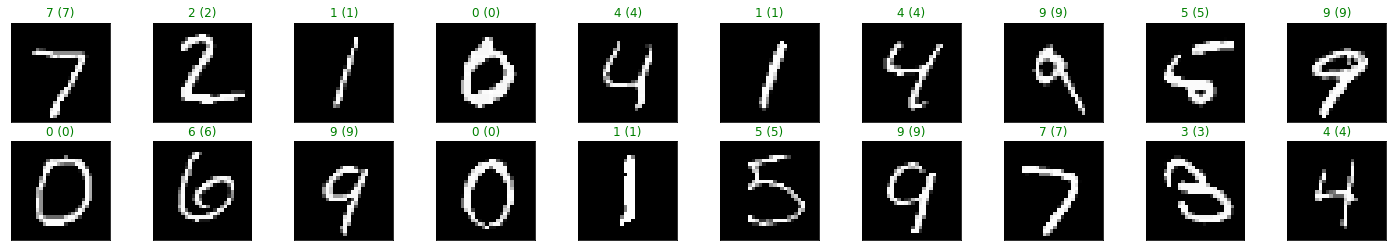

In [24]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(img_conver(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

### unsqueeze

In [26]:
x = torch.tensor([1, 2, 3, 4])
torch.unsqueeze(x, 0)

torch.unsqueeze(x, 1)

tensor([[1],
        [2],
        [3],
        [4]])